# MNIST using Distributed Keras

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

In [1]:
!(date +%d\ %B\ %G)

30 December 2016


In this notebook we will show you how to process the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using Distributed Keras. As in the [workflow](https://github.com/JoeriHermans/dist-keras/blob/master/examples/workflow.ipynb) notebook, we will guide you through the complete machine learning pipeline.

## Preparation

To get started, we first load all the required imports. Please make sure you installed `dist-keras`, and `seaborn`. Furthermore, we assume that you have access to an installation which provides Apache Spark.

Before you start this notebook, place the MNIST dataset (which is provided in this repository) on HDFS. Or in the case HDFS is not available, place it on the local filesystem. But make sure the path to the file is identical for all computing nodes.

In [2]:
%matplotlib inline

import numpy as np

import seaborn as sns

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *

from pyspark import SparkContext
from pyspark import SparkConf

from matplotlib import pyplot as plt

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In the following cell, adapt the parameters to fit your personal requirements.

In [3]:
# Modify these variables according to your needs.
application_name = "Distributed Keras MNIST Notebook"
using_spark_2 = False
local = False
path = "data/mnist.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_cores = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 10
    num_cores = 2

In [4]:
# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_cores

print("Number of desired executors: " + `num_executors`)
print("Number of desired cores / executor: " + `num_cores`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 10
Number of desired cores / executor: 2
Total number of workers: 20


In [5]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [6]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_cores`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "2g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [7]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferSchema='true') \
                    .load(path)
raw_dataset = raw_dataset.repartition(num_workers)

In [8]:
# Double-check the inferred schema, and get fetch a row to show how the dataset looks like.
raw_dataset.printSchema()
raw_dataset = raw_dataset.repartition(num_workers)

root
 |-- label: integer (nullable = true)
 |-- pixel0: integer (nullable = true)
 |-- pixel1: integer (nullable = true)
 |-- pixel2: integer (nullable = true)
 |-- pixel3: integer (nullable = true)
 |-- pixel4: integer (nullable = true)
 |-- pixel5: integer (nullable = true)
 |-- pixel6: integer (nullable = true)
 |-- pixel7: integer (nullable = true)
 |-- pixel8: integer (nullable = true)
 |-- pixel9: integer (nullable = true)
 |-- pixel10: integer (nullable = true)
 |-- pixel11: integer (nullable = true)
 |-- pixel12: integer (nullable = true)
 |-- pixel13: integer (nullable = true)
 |-- pixel14: integer (nullable = true)
 |-- pixel15: integer (nullable = true)
 |-- pixel16: integer (nullable = true)
 |-- pixel17: integer (nullable = true)
 |-- pixel18: integer (nullable = true)
 |-- pixel19: integer (nullable = true)
 |-- pixel20: integer (nullable = true)
 |-- pixel21: integer (nullable = true)
 |-- pixel22: integer (nullable = true)
 |-- pixel23: integer (nullable = true)
 |-- pi

As shown in the output of the cell above, we see that every pixel is associated with a seperate column. In order to ensure compatibility with Apache Spark, we vectorize the columns, and add the resulting vectors as a seperate column. However, in order to achieve this, we first need a list of the required columns. This is shown in the cell below.

In [9]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
features = raw_dataset.columns
features.remove('label')

features

['pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pixel83',
 '

Once we have a list of columns names, we can pass this to Spark's [VectorAssembler](http://spark.apache.org/docs/latest/ml-features.html#vectorassembler). This VectorAssembler will take a list of features, vectorize them, and place them in a column defined in `outputCol`.

In [10]:
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset = vector_assembler.transform(raw_dataset)

Once we have the inputs for our Neural Network (features column) after applying the VectorAssembler, we should also define the outputs. Since we are dealing with a classification task, the output of our Neural Network should be a one-hot encoded vector with 10 elements. For this, we provide a `OneHotTransformer` which accomplish this exact task.

In [11]:
# Define the number of output classes.
nb_classes = 10
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset = encoder.transform(dataset)

## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits. Every image is a 28 by 28 pixel grayscale image. This means that every pixel has a value between 0 and 255. Some examples of instances within this dataset are shown in the cells below.

In [12]:
def show_instances(column):
    global dataset

    num_instances = 6 # Number of instances you would like to draw.
    x_dimension   = 3 # Number of images to draw on the x-axis.
    y_dimension   = 2 # Number of images to draw on the y-axis.

    # Fetch 3 different instance from the dataset.
    instances = dataset.select(column).take(num_instances)
    # Process the instances.
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    # Draw the sampled instances.
    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

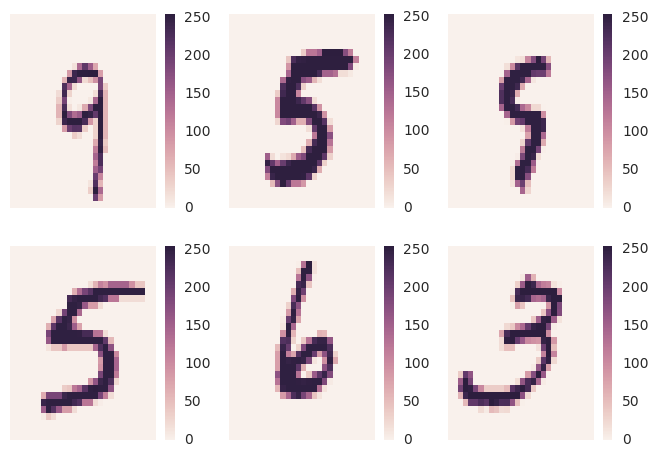

In [13]:
show_instances("features")

## Normalization

In this Section, we will normalize the feature vectors between the 0 and 1 range.

In [14]:
# Clear the dataset in the case you ran this cell before.
dataset = dataset.select("features", "label", "label_encoded")
# Allocate a MinMaxTransformer using Distributed Keras.
# o_min -> original_minimum
# n_min -> new_minimum
transformer = MinMaxTransformer(n_min=0.0, n_max=1.0, \
                                o_min=0.0, o_max=250.0, \
                                input_col="features", \
                                output_col="features_normalized")
# Transform the dataset.
dataset = transformer.transform(dataset)

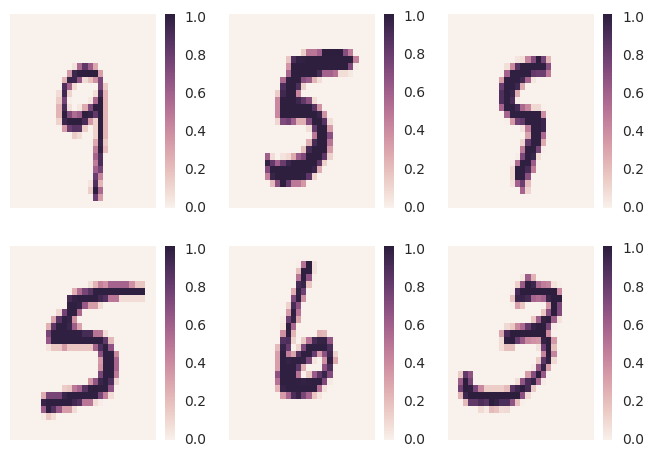

In [15]:
show_instances("features_normalized")

## Convolutions

In order to make the dense vectors compatible with convolution operations in Keras, we add another column which contains the matrix form of these images. We provide a utility class (MatrixTransformer), which helps you with this.

In [16]:
reshape_transformer = ReshapeTransformer("features_normalized", "matrix", (28, 28, 1))
dataset = reshape_transformer.transform(dataset)

## Model Development

### Multilayer Perceptron

In [17]:
mlp = Sequential()
mlp.add(Dense(1000, input_shape=(784,)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(200))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(10))
mlp.add(Activation('softmax'))

In [18]:
mlp.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1000)          785000      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1000)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1000)          0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 200)           200200      dropout_1[0][0]                  
___________________________________________________________________________________________

In [19]:
optimizer_mlp = 'adam'
loss_mlp = 'categorical_crossentropy'

### Convolutional network

In [20]:
# Taken from Keras MNIST example.

# Declare model parameters.
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)

# Construct the model.
convnet = Sequential()
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                          border_mode='valid',
                          input_shape=input_shape))
convnet.add(Activation('relu'))
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size=pool_size))
convnet.add(Dropout(0.25))

convnet.add(Flatten())
convnet.add(Dense(212))
convnet.add(Activation('relu'))
convnet.add(Dropout(0.5))
convnet.add(Dense(nb_classes))
convnet.add(Activation('softmax'))

In [21]:
convnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 26, 26, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 26, 26, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 24, 24, 32)    9248        activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 24, 24, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [22]:
optimizer_convnet = 'adam'
loss_convnet = 'categorical_crossentropy'

## Evaluation

We define a utility function which will compute the accuracy for us.

In [23]:
def evaluate_accuracy(model, test_set, features="features_normalized_dense"):
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="label")
    predictor = ModelPredictor(keras_model=model, features_col=features)
    transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = test_set.select(features, "label")
    test_set = predictor.predict(test_set)
    test_set = transformer.transform(test_set)
    score = evaluator.evaluate(test_set)
    
    return score

## Training

In [24]:
dataset.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- label_encoded: vector (nullable = true)
 |-- features_normalized: vector (nullable = true)
 |-- matrix: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)



In [25]:
dataset = dataset.select("features_normalized", "matrix","label", "label_encoded")

In [26]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset = dense_transformer.transform(dataset)
dataset.repartition(num_workers)

DataFrame[features_normalized: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: vector, features_normalized_dense: vector]

In [27]:
dataset = dataset.unionAll(dataset)

In [28]:
(training_set, test_set) = dataset.select("features_normalized_dense", "matrix", "label", "label_encoded").randomSplit([0.7, 0.3])
training_set.cache()
test_set.cache()

DataFrame[features_normalized_dense: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: vector]

In [29]:
print(training_set.count())

58774


### Sequential training (Multilayer Perceptron)

In [30]:
trainer = SingleTrainer(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, batch_size=8,
                        num_epoch=1, features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [31]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 403.427423954
Accuracy: 0.956711329581


### DOWNPOUR (Multilayer Perceptron)

In [32]:
trainer = DOWNPOUR(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                   batch_size=8, communication_window=5, learning_rate=0.1, num_epoch=1,
                   features_col="features_normalized_dense", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [33]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 123.770549059
Accuracy: 0.104138587172


In [34]:
trainer.parameter_server.num_updates

2951

### ADAG (MultiLayer Perceptron)

In [35]:
trainer = ADAG(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
               batch_size=8, communication_window=5, learning_rate=0.1, num_epoch=1,
               features_col="features_normalized_dense", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [36]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 235.734337091
Accuracy: 0.96432252438


In [37]:
trainer.parameter_server.num_updates

2931

### Sequential training (Convolutional network)

In [38]:
trainer = SingleTrainer(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
                        batch_size=8, num_epoch=1, features_col="matrix", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [39]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 838.073318005
Accuracy: 0.987235392056


### DOWNPOUR (Convolutional network)

In [40]:
trainer = DOWNPOUR(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
                   num_workers=num_workers, batch_size=8, communication_window=5, learning_rate=0.1,
                   num_epoch=1, features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [41]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 153.944876194
Accuracy: 0.10061048125


In [42]:
trainer.parameter_server.num_updates

2951

### ADAG (Convolutional network)

In [43]:
trainer = ADAG(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
               num_workers=num_workers, batch_size=8, communication_window=5, num_epoch=1,
               features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [44]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 131.51503396
Accuracy: 0.977324982161


In [45]:
trainer.parameter_server.num_updates

2931

## Algorithm performance

In this section we will be evaluating the models produced by the different distributed numerical optimizers. In this case we will be evaluating DOWNPOUR, which is a common method introduced by Dean et al., and ADAG (Asynchronous Distributed Adaptive Gradients), which is ours. The will be conducted in the following way: for every optimizer, we will run a training and evaluation run 20 times. When the results are collected we will draw some plots which include error-bars. This will give us 

In [46]:
# Define the number of experiments.
num_experiments = 30
# Define the result storage.
results = {}
results['downpour'] = {}
results['downpour']['data'] = []
results['downpour']['std_acc'] = 0
results['downpour']['mean_acc'] = 0
results['downpour']['std_time'] = 0
results['downpour']['mean_time'] = 0
results['downpour']['training_time'] = []
results['adag'] = {}
results['adag']['data'] = []
results['adag']['std_acc'] = 0
results['adag']['mean_acc'] = 0
results['adag']['std_time'] = 0
results['adag']['mean_time'] = 0
results['adag']['training_time'] = []
results['single'] = {}
results['single']['data'] = []
results['single']['std_acc'] = 0
results['single']['mean_acc'] = 0
results['single']['std_time'] = 0
results['single']['mean_time'] = 0
results['single']['training_time'] = []

# Run the DOWNPOUR experiment.
for i in range(0, num_experiments):
    # Define the trainer.
    trainer = DOWNPOUR(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                       batch_size=4, communication_window=5, num_epoch=1, features_col="features_normalized_dense",
                       label_col="label_encoded")
    trainer.set_parallelism_factor(1)
    trained_model = trainer.train(training_set)
    # Evaluate the trained model.
    accuracy = evaluate_accuracy(trained_model, test_set)
    training_time = trainer.get_training_time()
    # Store the obtained result.
    results['downpour']['data'].append(accuracy)
    results['downpour']['training_time'].append(training_time)
    # Print some debugging information during the experiments.
    print("DOWNPOUR Experiment " + str(i + 1) + ": " + str(accuracy))

# Run the ADAG experiment.
for i in range(0, num_experiments):
    # Define the trainer.
    trainer = ADAG(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                   batch_size=4, communication_window=5, num_epoch=1, features_col="features_normalized_dense",
                   label_col="label_encoded")
    trainer.set_parallelism_factor(1)
    trained_model = trainer.train(training_set)
    # Evaluate the trained model.
    accuracy = evaluate_accuracy(trained_model, test_set)
    training_time = trainer.get_training_time()
    # Store the obtained result.
    results['adag']['data'].append(accuracy)
    results['adag']['training_time'].append(training_time)
    # Print some debugging information during the experiments.
    print("ADAG Experiment " + str(i + 1) + ": " + str(accuracy))
    
# Run sequential experiment.
for i in range(0, num_experiments):
    # Define the trainer.
    trainer = SingleTrainer(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, batch_size=4,
                        num_epoch=1, features_col="features_normalized_dense", label_col="label_encoded")
    trained_model = trainer.train(training_set)
    # Evaluate the trained model.
    accuracy = evaluate_accuracy(trained_model, test_set)
    training_time = trainer.get_training_time()
    # Store the obained result.
    results['single']['data'].append(accuracy)
    results['single']['training_time'].append(training_time)
    # Print some debugging information during the experiments.
    print("Sequential Experiment " + str(i + 1) + ": " + str(accuracy))

DOWNPOUR Experiment 1: 0.192024102117
DOWNPOUR Experiment 2: 0.104138587172
DOWNPOUR Experiment 3: 0.192499801792
DOWNPOUR Experiment 4: 0.104138587172
DOWNPOUR Experiment 5: 0.193213351304
DOWNPOUR Experiment 6: 0.193015143106
DOWNPOUR Experiment 7: 0.191112344407
DOWNPOUR Experiment 8: 0.192975501467
DOWNPOUR Experiment 9: 0.104138587172
DOWNPOUR Experiment 10: 0.104138587172
DOWNPOUR Experiment 11: 0.104138587172
DOWNPOUR Experiment 12: 0.104138587172
DOWNPOUR Experiment 13: 0.104138587172
DOWNPOUR Experiment 14: 0.19265836835
DOWNPOUR Experiment 15: 0.104138587172
DOWNPOUR Experiment 16: 0.104138587172
DOWNPOUR Experiment 17: 0.189566320463
DOWNPOUR Experiment 18: 0.104138587172
DOWNPOUR Experiment 19: 0.189011337509
DOWNPOUR Experiment 20: 0.104138587172
DOWNPOUR Experiment 21: 0.190200586696
DOWNPOUR Experiment 22: 0.104138587172
DOWNPOUR Experiment 23: 0.184373265678
DOWNPOUR Experiment 24: 0.191548402442
DOWNPOUR Experiment 25: 0.104138587172
DOWNPOUR Experiment 26: 0.104138587

In [47]:
# Compute standard deviation and mean for every experiment.
for k in results.keys():
    results[k]['mean_acc'] = np.mean(results[k]['data'])
    results[k]['std_acc'] = np.std(results[k]['data'])
    results[k]['mean_time'] = np.mean(results[k]['training_time'])
    results[k]['std_time'] = np.std(results[k]['training_time'])

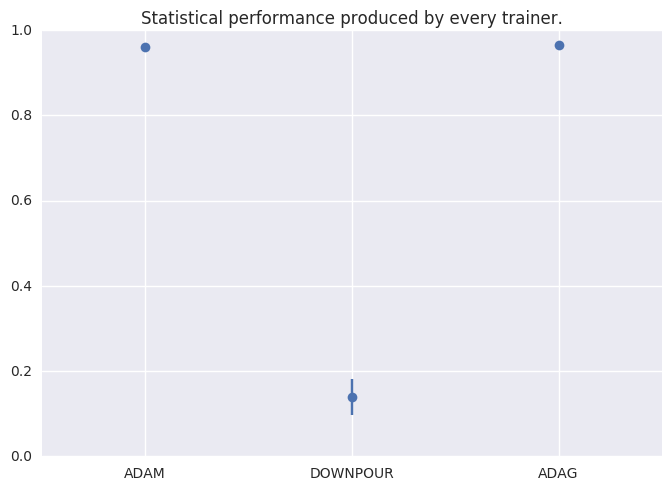

In [60]:
# Retrieve an array of means and standard deviations of accuracy.
means = []
stds = []
# Fetch the data from all the experiments.
for k in results.keys():
    mean = results[k]['mean_acc']
    std = results[k]['std_acc']
    means.append(mean)
    stds.append(std)
    
# Plot the data.
plt.figure()
x = np.array([0, 1, 2])
plt.errorbar(x, means, xerr=0, yerr=stds, fmt='o')
plt.title("Statistical performance produced by every trainer.")
plt.xlim([-0.5,2.5])
plt.ylim([0.0, 1])
keys = results.keys()
# Keys to upper case.
for i in range(0, len(keys)):
    keys[i] = keys[i].upper()
keys[0] = "ADAM"
plt.xticks(range(len(keys)), keys)
plt.show()

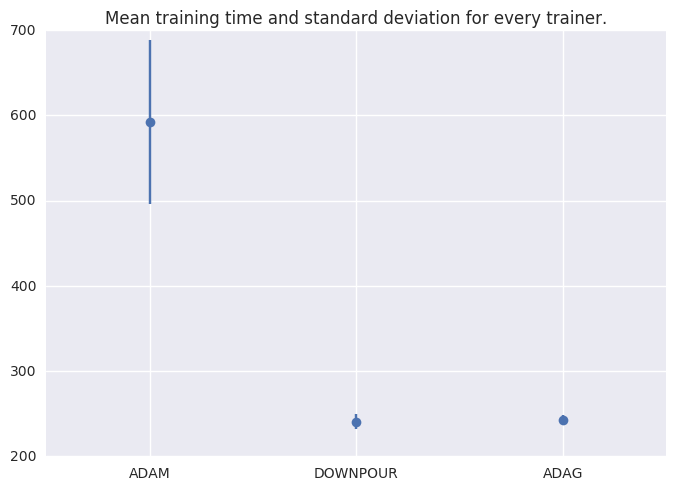

In [59]:
# Retrieve an array of means and standard deviations of training time.
means = []
stds = []
# Fetch the data from all the experiments.
for k in results.keys():
    mean = results[k]['mean_time']
    std = results[k]['std_time']
    means.append(mean)
    stds.append(std)
    
# Plot the data.
plt.figure()
x = np.array([0, 1, 2])
plt.errorbar(x, means, xerr=0, yerr=stds, fmt='o')
plt.title("Mean training time and standard deviation for every trainer.")
plt.xlim([-0.5,2.5])
keys = results.keys()
# Keys to upper case.
for i in range(0, len(keys)):
    keys[i] = keys[i].upper()
keys[0] = "ADAM"
plt.xticks(range(len(keys)), keys)
plt.show()